In [350]:
import pygad 
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, skew
from numba import int32, float64   # import the types
from portfolio_simulator import PortfoliosSimulator


In [434]:
def expected_returns(period):
    return pd.Series({
		'ACWI': 0.07/period,
		'^TBSP': 0.035/period,
		'XAUPLN': 0.05/period,
		'MWIG40': 0.065/period,
		'IHYU.L': 0.038/period,
		'PLOPLN3M': 0.03/period,
		'edo': 0.032/period
})

""" cov = np.array([[0.001265,	0.000042],
            	[0.000042,	0.000164]]) """
#acwi edo
cov = np.array([[0.030276,	0.0],
            	[0.0,	0.00021]])
cov_y = cov 

In [435]:
np.round(0.0145**2,6)

0.00021

In [436]:
np.sqrt(0.003211*12)
np.round(0.174**2,6)


0.030276

In [510]:
assets = ['ACWI', 'edo']
means = expected_returns(1)[assets]
number_of_scenarios = 1000
T = 50
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov_y, T))

sim_returns = np.array(sim_returns)
sim_returns.shape

(1000, 50, 2)

In [500]:
means = sim_returns.mean(1)

result = pd.DataFrame({},index=['mean','0.25','0.5','0.75'])
result.loc['mean','mean'] = means[0].mean()
result.loc['mean','mean_ann'] = means[0].mean() *12
result.loc['mean','std'] = means[0].std()
result.loc['mean','skewsness'] = skew(means[0])

sorted = np.sort(means,0)
result.loc['0.25','mean'] = sorted[len(means)//4*1].mean()
result.loc['0.25','mean_ann'] = sorted[len(means)//4*1].mean() *12
result.loc['0.25','std'] = sorted[len(means)//4*1].std() 
result.loc['0.5','mean'] = sorted[len(means)//4*2].mean()
result.loc['0.5','mean_ann'] = sorted[len(means)//4*2].mean() *12
result.loc['0.5','std'] = sorted[len(means)//4*2].std() 
result.loc['0.75','mean'] = sorted[len(means)//4*3].mean()
result.loc['0.75','mean_ann'] = sorted[len(means)//4*3].mean() *12
result.loc['0.75','std'] = sorted[len(means)//4*3].std() 
result


,mean,mean_ann,std,skewsness
mean,0.039036,0.468432,0.006720,0.0
0.25,0.042115,0.505376,0.011457,NaN
0.5,0.051668,0.620012,0.019729,NaN
0.75,0.060675,0.728105,0.027340,NaN


In [501]:
spec = [
    ('capital', float64),
    ('returns', float64[:,:,:]),
    ('strategy', float64[:,:]),
    ('inflows', int32[:])
]
#@jitclass(spec)
class Simulation():
    def __init__(self, initial_value, inflows, returns, strategy) -> None:
        self.capital = initial_value
        self.returns = returns
        self.strategy = strategy 
        self.inflows = inflows
        
    def step(self, current_value,inflow,weights,returns):
        current_assets_value = np.expand_dims(current_value+inflow,axis=0).T * weights
        next_assets_value =  np.round(current_assets_value * (1+returns),2)
        return next_assets_value.sum(1)
         
    def run(self, T):
        for t in range(T):
            self.capital = self.step(self.capital,self.inflows[t],self.strategy[t],self.returns[:,t])


In [502]:
portfolios = [[0.0,1.0],
             [0.1,0.9],
             [0.2,0.8],
             [0.3,0.7],
             [0.4,0.6],
             [0.5,0.5],
             [0.6,0.4],
             [0.7,0.3],
             [0.8,0.2],
             [0.9,0.1],
             [1.0,0.0]]

In [511]:
T = 50
capital = 50000
inflows = np.cumproduct(np.full(T,1.02))*26000

l = np.arange(T,0,-1)
risk = 30

glide_paths = np.full(T+1,len(portfolios))
perc = np.zeros((l.shape[0],len(portfolios)))

for t in l:
    
    for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        #perc.append(np.percentile(simulator.capital,risk))
        perc[t-1,portfolio] = np.round(np.percentile(simulator.capital,risk))
    glide_paths[t-1] = np.argmax(perc[t-1])

#glide = list(glide_paths.values())
np.flip(glide_paths)[1:]

    #TODO for portfolio in range(len(portfolios)) na range(glide_paths[t-1])

array([10, 10,  9, 10, 10,  9, 10, 10, 10, 10,  9, 10,  8, 10,  9,  9,  9,
        9,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  8,  8,  6,  6,  7,  7,
        7,  8,  4,  6,  6,  4,  4,  5,  4,  4,  2,  2,  2,  1,  1,  0])

array([ 9, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9, 10,  9, 10, 10,  9,
        9, 10,  8, 10,  9,  9,  9,  9,  9,  9,  8, 10, 10,  9,  8,  7,  6,
        7,  7,  6,  4,  5,  2,  4,  3,  2,  3,  2,  1,  1,  1,  1,  0])

10  
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 0, 0, 0, 0, 0, 0]

20  
  [7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4,
   4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
   1, 1, 1, 0, 0, 0]

30
 [ 9,  9, 9,  9,  9,  9,  9,  9,  9, 9,  9, 9, 9,  9, 9, 9, 9,
   9, 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,
   7,  6,  5,  5,  5,  3,  3,  3,  3,  2,  2,  2,  1,  1,  1,  1]
 

40
  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
   10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
   10, 10, 10, 10,  10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  5,  3]

50
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [100]:
fitness(None,glide,None)

368.34

In [101]:
T=15
risk = 0.25
perc = []
for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))

In [102]:
simulator = Simulation(100,np.full(T,0), sim_returns,glide)
simulator.run(T)
#np.percentile(simulator.capital,risk)
end_capital = simulator.capital

In [103]:
r = 0.4
T = 15
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)
    

In [104]:
fitness(None,glide,None)

170.29

In [450]:
def initial_population(T,number_porfolios,solutions):
    population = np.zeros((solutions,T))
    population[11:,0] = np.random.randint(0,number_porfolios+1, solutions-11)
    for t in range(1,T):
        population[11:,t] = np.random.randint(0,population[11:,t-1]+1, solutions-11)
    for p in range(0,11):
        population[p,:] = p
    return population

In [451]:
def init2(portfolios,T, population_size):
    population = np.zeros((population_size, T))
    random_size = population_size-len(portfolios) 
    population[0:random_size] = np.random.choice(gen_space,(random_size,T))
    for p in range(len(portfolios)):
        population[random_size+p,:] = p
    return np.flip(np.sort(population,1),1)

In [452]:
def init3(portfolios,T, population_size):
    population = np.zeros((len(portfolios), T))
    for p in range(len(portfolios)):
        population[p,:] = p  
    ranges = [(3,11),(5,11),(7,21),(9,21),(11,21)]
    for r in ranges:
        rp = np.random.randint(0,r[0],(r[1],T))
        population = np.append(population, rp, axis=0)
    return np.flip(np.sort(population,1),1)


In [453]:
def isDescending(arr):
    diff = np.diff(arr)
    return np.all(diff <= 0)

def m_crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        random_split_point = np.random.choice(range(1,offspring_size[1]))

        result = parent1.copy()
        result[random_split_point:] = parent2[random_split_point:]
        if isDescending(result) != True:
            result = parent2.copy()
            result[random_split_point:] = parent1[random_split_point:]
           
        offspring.append(result)      

        idx += 1

    return np.array(offspring)

In [454]:
def m_crossover_func2(parents, offspring_size, ga_instance):
    offspring = []
   
    while len(offspring) != offspring_size[0]:
        
        idx = np.random.choice(ga_instance.num_parents_mating,2)
       
        if (np.random.uniform() <= ga_instance.crossover_probability):
            parent1 = parents[idx[0], :].copy()
            parent2 = parents[idx[1], :].copy()
            random_split_point = np.random.choice(range(1,offspring_size[1]))


            result = parent1.copy()
            result[random_split_point:] = parent2[random_split_point:]
            if isDescending(result) != True:
                result = parent2.copy()
                result[random_split_point:] = parent1[random_split_point:]
           
            offspring.append(result)
        else:
            offspring.append(parents[idx[0], :].copy())      
              
    return np.array(offspring)

In [455]:
def applyMutation(offset, mutation_idx, mutation_value):
    result = offset
    newValue = offset[mutation_idx] + mutation_value
    result[mutation_idx] = newValue
    if(mutation_value> 0):
        diff = offset[0:mutation_idx] - newValue
        result[0:mutation_idx] = np.where(diff < 0, offset[0:mutation_idx] - diff , offset[0:mutation_idx])
    else:
        diff = offset[mutation_idx+1:] - newValue
        result[mutation_idx+1:] = np.where(diff > 0, offset[mutation_idx+1:] - diff , offset[mutation_idx+1:])
    return result

def mutation_func(offspring, ga_instance):
    
    for chromosome_idx in range(offspring.shape[0]):
        if (np.random.random() <= ga_instance.mutation_probability):  
            random_gene_idx = np.random.choice(range(offspring.shape[1]))
            mutated_value = np.random.randint(ga_instance.random_mutation_min_val,ga_instance.random_mutation_max_val)
            result = applyMutation(offspring[chromosome_idx],random_gene_idx,mutated_value)
            result = np.where(result > np.max(ga_instance.gene_space), np.max(ga_instance.gene_space), result)
            result = np.where(result < np.min(ga_instance.gene_space), np.min(ga_instance.gene_space), result)
            offspring[chromosome_idx] = result
            
    return offspring

#TODO zabezpieczyc mutation <= max porfolio

In [491]:
r = 0.3
T = 5
inflows = np.cumproduct(np.full(T,1.02))*26000
initial_capital = 50000 
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(initial_capital,inflows,sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r) #// 1

In [492]:
sol_per_pop = 100
num_genes = T
num_parents_mating = 10
keep_parents = 1
gene_type= int
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
parent_selection_type = 'tournament'
crossover_type = "single_point"
num_generations= 200
fitness_function = fitness
mutation_type = mutation_func #"random"
#mutation_percent_genes = 10
random_mutation_min_val=-2.0
random_mutation_max_val=2.0
mutation_probability=0.4
crossover_probability=0.6
crossover_func=m_crossover_func2
stop_criteria = "saturate_200"
initial_pop = init3(portfolios,T,100) #initial_population(T,10,100)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gen_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       mutation_probability=mutation_probability,
                       crossover_probability=crossover_probability,
                       crossover_type= crossover_func,
                       stop_criteria = stop_criteria,
                       save_solutions=True
                       )

In [493]:
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [494]:
print(solution)
print(solution_fitness)

[3 3 2 1 1]
209227.44999999998


In [238]:
np.sum([8, 8, 6, 6, 4, 4, 4, 4, 3, 3])

50

c =100 i=10  
[6 5 4 4 4 4 4 4 4 4]  

c=0 i=10  
[10 10  5  5  5  5  5  5  5  5]

g=0  
[7 4 4 4 4 4 3 3 3 3]

g=0.02  
[10 10  6  5  5  5  5  4  4  4]

g=0.06
[8 6 6 4 4 4 4 4 4 3]

In [476]:
r = 0.30
T = 25
inflows = np.cumproduct(np.full(T,1.02))*0
initial_capital = 1 #67746
CV =0
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(initial_capital,inflows,sim_returns, weights)
    portfolio_sim.run(T)
    global CV 
    CV = np.sort(portfolio_sim.capital)
    return np.quantile(portfolio_sim.capital,r) 

fitness(None,[ 9,  9, 9,  9,  9,  9,  9,  9,  9, 9,  9, 9, 9,  9, 9, 9, 9,
   9, 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,
   7,  6,  5,  5,  5,  3,  3,  3,  3,  2,  2,  2,  1,  1,  1,  1],None)


2.66

2.69
2.66

In [481]:
goal = 1112000
required_capital = goal/2.66
required_capital

418045.1127819549

In [ ]:
A = 120000
V = A/1.78
print(V)
inflows = np.cumproduct(np.full(T,1.02))*4300
dr = 0.035
d = np.cumproduct(np.full(T,1+dr))
Ic = np.sum(inflows/d)
print(Ic)
np.round(V/Ic,2)


67415.73033707865
67570.0500871803


1.0

In [ ]:
1.78**(1/18)

1.0325526897590842

In [ ]:
2000/12
#/14400

166.66666666666666

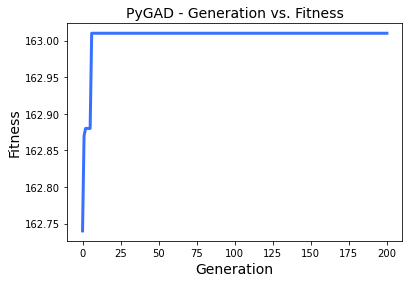

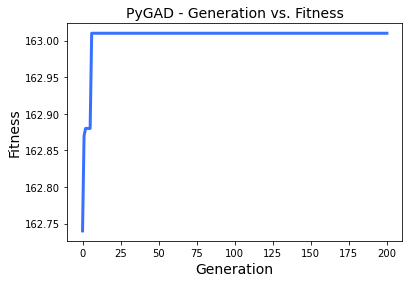

In [262]:
ga_instance.plot_fitness()

[ 0  0  0  7  3  0  8  6  0  5  4  2  8  4  1 10  6  8  9  3  9 10  8  9
  9  3  4  7  1  5  3  3  7  5  1 10 10  9  8  4  4  4  5  9  7  6  5  5
  6  8  5  1  3  9  2  4  5  2  0  7]
129.62

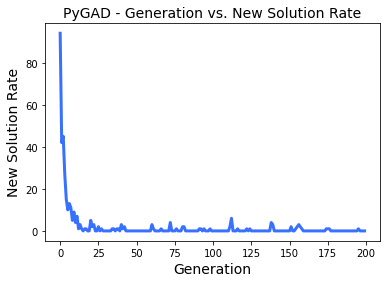

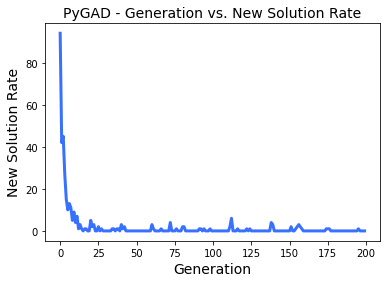

In [257]:
ga_instance.plot_new_solution_rate()

In [ ]:
#[6, 3, 3, 3, 2]
fitness(None,[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3],0)


1713.76

In [ ]:
from unittest.mock import patch

def mock_rand(range):
        return 0


parents = np.array([[4,3,3,2,2],
                     [7,6,5,2,1]])

result = None

""" with patch('numpy.random.choice',mock_rand):
    result = crossover_func(parents, (1,5), None) """

crossover_func(parents, (1,5), None)
#result

array([[4, 3, 3, 2, 1]])

In [ ]:
arr = [4,3,3,3,3]
arr[:0]

[]

In [ ]:
offspring = np.array([[10,10,8,8,6,6]])
mutation_func(offspring, ga_instance)

array([[10, 10,  8,  8,  6,  6]])

In [ ]:
import random
probs = np.random.random(size=20)
indices = np.where(probs <= 0.6)[0]
random.sample(list(set(indices)), 2)

[17, 9]

In [ ]:
4320.0

4320.0

In [ ]:
parents = np.array([[9,9,7,7,5,5],
                    [8,8,6,6,4,4],
                    [3,3,2,2,1,1],
                    [12,12,11,11,10,10]])
class GA:
    crossover_probability = 0.6
    
m_crossover_func2(parents,(4,6),GA())

array([[ 3,  3,  2,  2,  1,  1],
       [12, 12, 11, 11, 10,  4],
       [ 8,  8,  6,  6,  4,  4],
       [12, 12, 11, 11, 10,  1]])

In [134]:
print(np.count_nonzero(initial_pop == 0,axis=0))
print(np.count_nonzero(initial_pop == 1,axis=0))
print(np.count_nonzero(initial_pop == 2,axis=0))
print(np.count_nonzero(initial_pop == 3,axis=0))
print(np.count_nonzero(initial_pop == 4,axis=0))
print(np.count_nonzero(initial_pop == 5,axis=0))
print(np.count_nonzero(initial_pop == 6,axis=0))
print(np.count_nonzero(initial_pop == 7,axis=0))
print(np.count_nonzero(initial_pop == 8,axis=0))
print(np.count_nonzero(initial_pop == 9,axis=0))
print(np.count_nonzero(initial_pop == 10,axis=0))

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  4  6  9 14 19
 26 38 51 64 74 84]
[ 1  1  1  1  1  1  3  4  5  5  5  9 10 11 12 13 15 18 20 23 26 32 32 37
 38 35 28 21 13  3]
[12 12 12 12 12 12 10  9  9  9 10 10 15 16 16 20 22 20 20 24 27 30 28 22
 18 15  9  3  1  1]
[ 1  1  1  3  4  7  8 10 14 15 16 16 12 14 17 17 17 24 28 30 25 16 13 11
  7  1  1  1  1  1]
[12 12 12 11 10 11 14 13 10 11 14 15 17 17 22 21 26 21 15  8  6  3  3  1
  1  1  1  1  1  1]
[ 1  2  7 10 12 13 12 13 13 16 15 16 18 18 13 12  6  5  5  2  1  1  1  1
  1  1  1  1  1  1]
[22 22 17 13 13 11 10 11 16 15 17 16 13 11 10  8  5  3  1  1  1  1  1  1
  1  1  1  1  1  1]
[ 2  5  6 11 12 14 14 18 16 16 11  9  7  5  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
[21 17 17 13 12 10 18 12  7  6  5  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
[ 1  5  7 10 15 13  5  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
[22 18 15 11  4  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

In [ ]:
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)

class Fitness(simulator, objective_function):
    
    def __init__(self) -> None:
        self.simulator = simulator
        self.objective_function

In [318]:
means = [0.07, 0.04]
cov = np.array([[0.003211,	0.0],
            	[0.0,	0.000011]])
cov = cov * 12

number_of_scenarios = 1000
T = 20
prices = []

for i in range (number_of_scenarios):
    returns = multivariate_normal.rvs(means,cov, T) + 1
    prices.append(np.cumprod(returns,axis=0)*100)
    #prices.append(returns)

prices = np.absolute(prices)
prices = np.round(prices,2)

In [342]:
model = PortfoliosSimulator()
solution = np.full(T,6)
weights = np.take(portfolios, solution,axis=0)
goals = {
    10: (60000,1),
    18: (140000,1)}
model.set_params(prices,weights,np.full(20,12000),goals)
model.run()
outflows = model.get_outflows()    


In [344]:
np.count_nonzero(np.array(outflows) >= np.array([[60000],[140000]]))


1973

In [348]:
arr1 = [[3,4],[5,6]]
arr2 = [[2],[5]]
np.all(arr1 > arr2,axis=0)

True